<a href="https://colab.research.google.com/github/yuvalwas/MDAN-course/blob/main/MDAN_T1_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports and helpers
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import numpy as np
import scipy as sp
from scipy.stats import binom, beta, poisson, geom, t as tdist
from scipy import optimize
import seaborn as sns
# sns.set_style("dark")

def hdi(posterior, hdi_percent=0.95):
  density_threshold = hdi_percent * posterior.sum()
  idxs = np.argsort(posterior)
  idxs = np.flip(idxs) 
  pos = posterior[idxs] / posterior.sum()
  threshold_idx = np.searchsorted(np.cumsum(posterior[idxs]), density_threshold)
  assert (posterior[idxs[:threshold_idx]].sum() < density_threshold) and (posterior[idxs[:threshold_idx+1]].sum() > density_threshold)
  idxs = idxs[:threshold_idx]
  idxs.sort()
  return idxs

**Models and data analysis in neuroscience - tutorial 1** <br>
Welcome to the statistics tutorial! Today we'll introduce Bayesian statistics and compare it to frequentist (classical) statistics by performing two common statistical procedures (that you should be somewhat familiar with from your statistics course) in their frequentist and Bayesian versions.

# Binomial test
Suppose someone has a coin that we know to be a regular, unaltered coin freshly minted
by a federal government. The person flips (or spins) the coin 20 times and it happens to come up heads 17 times, that is, 85% heads. What do you believe to be the underlying
probability of heads for the coin? Despite the result from the 20 flips, the strong prior knowledge about the coin suggests that the result was likely a fluke and that the underlying probability of heads is, nevertheless, ~0.5.

**Notation**
- $n$ = number of coin flips
- $k$ = number of heads
- $p$ = probability to get heads in a single flip

## How would frequentist statistics deal with this?
### Hypothesis testing

The most straightforward thing to do is hypothesis testing, and specifically, a binomial test. 

1. **Define a specific model we want to reject** <br>
First of all, we state a null hypothesis, denoted by H0 (which we want to reject) 
$$ H_0 : p = 0.5 $$
    
2. **Build a null distribution** <br>
This distribution gives the probability to get $k$ heads out of 20 coin flips, **given $H_0$ is true**, i.e., $p=0.5$, for every $k=0,1,...,20$. This distribution is $\text{Binomial}(20, 0.5)$. Let's see it:

In [ ]:
p = 0.5 #@param 
n = 20 #@param # number of coin flips 
k = 17 #@param # heads in data
ks = np.arange(n+1) # values of k to evaluate the distribution in
H0distribution = binom(n, p)
PMF = H0distribution.pmf(ks) # probability mass function

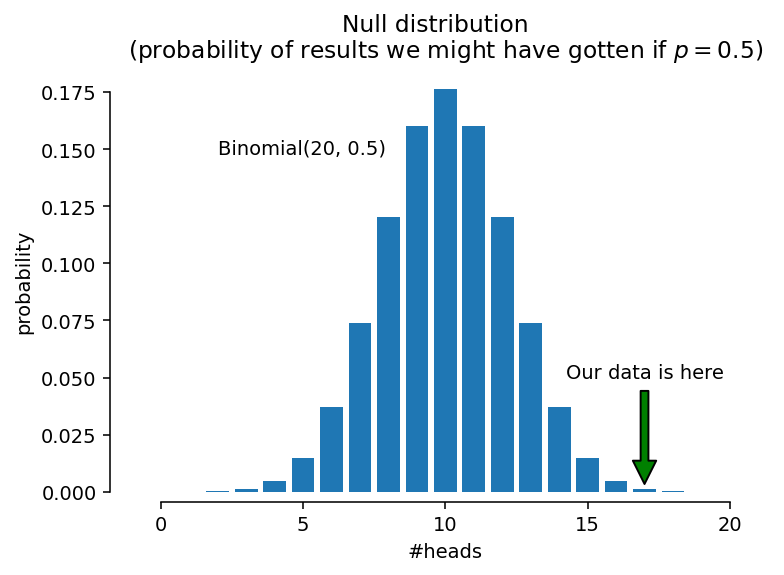

In [ ]:
#@title Plot null distribution
plt.bar(ks, PMF)
plt.gca().set(xlabel='#heads', ylabel='probability', title=f'(probability of results we might have gotten if $p={p}$)')#')
plt.annotate("Our data is here", xy=(k, PMF[k]), xytext=(k, 0.05), 
             arrowprops = dict(facecolor ='green', shrink = 0.05),
            horizontalalignment='center')
sns.despine(trim=True, offset=5)
plt.suptitle(f'Null distribution')
plt.annotate(f'Binomial{n, p}', xy=(0.15, 0.8), xycoords='axes fraction');

3. **Reject or retain the null hypothesis according to the *likelihood* of the data given the $H_0$ model** <br>
Now we compute the p-value. The p-value is the probability to get a result as or more extreme than what we got (again, under $H_0$). Here it is the probability to get a result $k\ge17$, or, symmetrically extreme, $k\le3$.

In [ ]:
p_value = PMF[:n-k+1].sum() + PMF[k:].sum() 
print(f'p-value = P(k≥{k} or k≤{n-k} | p=0.5) = {p_value:.3f}')

p-value = P(k≥17 or k≤3 | p=0.5) = 0.003


Because this probability is small, we conclude that our initial assumption that $p=0.5$ (H0) is probably wrong (since it led us to a very unlikely conclusion). 

### Important remarks
1. No where in the analysis did we use the fact that we are very confident that the coin is unbiased! If we would change the background story such that the coin was given to you by a magician, the analysis would have been the same.
2. Hypothesis testing doesn't tell us what model is probable. It can only tells us that a specific model is unlikely.

**Notation warning** - too many p's!<br>
- $P(??)$ = probability of ??
- $P(?? | 😀)$ = probability of ??, given that 😀 is true
- $p = P$(Heads) is parameter of the distribution, the chance for heads on a single coin toss
- p-value = $P$(our result or a more extreme one | $p=0.5$)

### Estimation
Okay - so we rejected the possibility that the coin is biased. What now? what $p$ is likely to be? <br>
Two basic options:
1. **Point estimation** <br>
Here we need to choose a single value as an estimation for $p$. Our guess would be just $p=\frac{17}{20}$. Although it is very likely to be something different, this is the best single value. More precisely, it maximizes the *likelihood*
$$ \frac{17}{20} = \arg\max_p P(k=17 | p) $$
and thus is called the **maximum likelihood estimator (MLE)**. 

Let's see the likelihood function:

In [ ]:
p_step_size = 0.001
ps = np.arange(0, 1+p_step_size, p_step_size) # In principle, we want the likelihood for every possible value of p between 0 and 1, however, we can only compute in with some finite resolution.
likelihood = binom.pmf(k, n, ps)

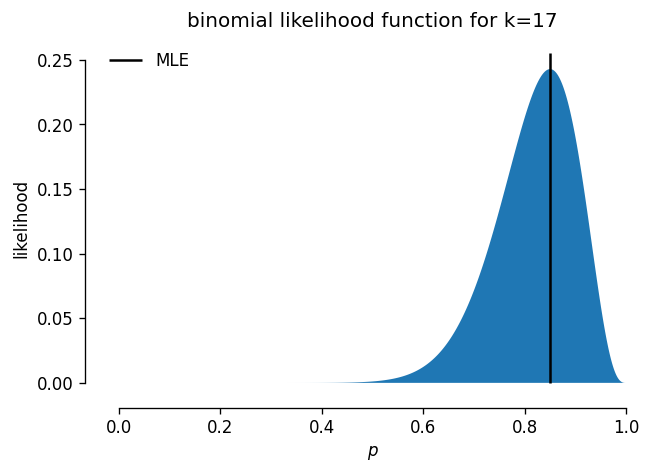

In [ ]:
#@title Plot likelihood function
plt.figure(dpi=120)
plt.fill_between(ps, likelihood)
plt.vlines(k/n, ymin=0, ymax=plt.axis()[-1], label='MLE')

plt.legend(loc='upper left', frameon=False)
plt.gca().set(xlabel='$p$', ylabel='likelihood', title=f'binomial likelihood function for k={k}')
sns.despine(trim=True, offset=5);

This is a function of $p$ for a fixed $k$, unlike the PMF which is a function of $k$ for a fixed $p$. Although every output is a probability, it is **not a probability function** - it does not sum to one.

2. **Confidence interval** <br>

## Bayesian statistics

Now the focus shifts from the *likelihood* function to the *posterior* distribution. The main difference is that now we can take prior information into account. We remind that 
$$ P(p | k=17) \propto P(k=17 | p) \cdot P(p) \\
P(\text{model | data}) \propto P(\text{data | model}) \cdot P(\text{model}) \\
\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$
where the $\propto$ means that the distribution on the left side *looks like* the function on the right side, it just needs to be mutliplied by some constant so that it would sum to one (but it doesn't affect the shape).<br>
We want to compute the posterior probability for every $p$ between 0 to 1, with k is fixed to be as in the data.

First of all, we need the likelihood function. We already computed and plotted it (see above). So what is left is determining the prior. The prior is the distribution of $p$ that reflects our beliefs regarding what $p$ might be, before seeing the data. For binary (coin flip) data, we always use the Beta distribution as a prior for $p$. We reflect our confidence that the coin is unbiased with a strong prior around $p=0.5$. Then, we multiply the prior with the likelihood to get the posterior distribution.

In [ ]:
#@title Strong prior - if I'm sure the coin is approximately fair
α, β = 50, 50 #@param 
prior_distribution = beta(α, β) 
prior = prior_distribution.pdf(ps)
posterior = likelihood * prior
posterior /= sum(posterior) * p_step_size


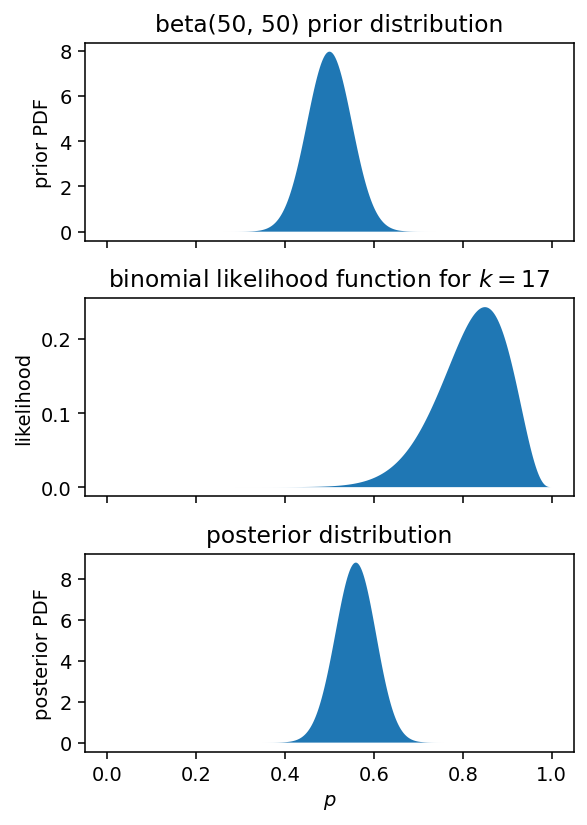

In [ ]:
#@title plot strong prior
fig, axs = plt.subplots(3, 3, sharey='row', figsize=(12,6), sharex='col')
axs[0,0].fill_between(ps, prior)
axs[0,0].set_ylabel('prior PDF')
axs[0,0].set_title(f'beta{α,β} prior distribution');
axs[1,0].fill_between(ps, likelihood)
axs[1,0].set_ylabel('likelihood')
axs[1,0].set_title(f'binomial likelihood function for $k={k}$')
axs[2,0].fill_between(ps, posterior)
axs[2,0].set_xlabel('$p$')
axs[2,0].set_ylabel('posterior PDF')
axs[2,0].set_title('posterior distribution')

for ax in axs.T.flatten()[3:]: ax.set_visible(False)
plt.tight_layout()

The posterior distribution is a compromise between the likelihood (the data) and the prior (our beliefs before seeing the data)!

What would have happened had we taken a prior with more uncertainty? And what about a flat (uniform) prior?

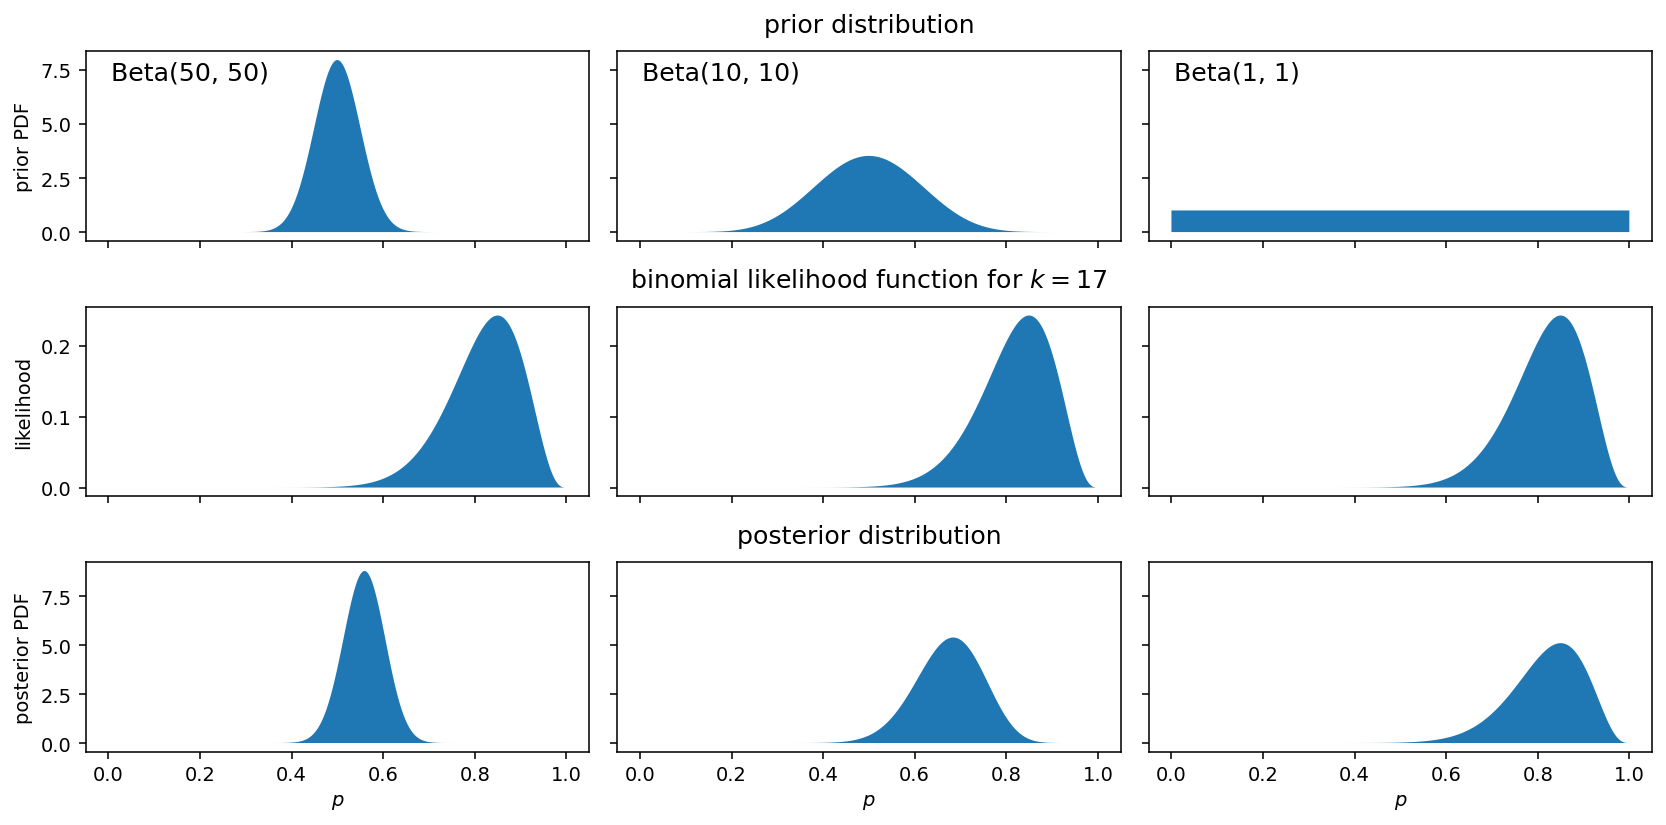

In [ ]:
#@title Plot different priors

for ax in axs.T.flatten()[3:]: 
  ax.clear()
  ax.set_visible(True)
for ax in axs.T.flatten()[:3]: ax.set_title('')

# less certain prior
α2, β2 = 10, 10 #@param
prior_distribution = beta(α2, β2) 
prior = prior_distribution.pdf(ps)
posterior = likelihood * prior
posterior /= sum(posterior) * p_step_size

axs[0,1].fill_between(ps, prior)
axs[0,1].set_title(f'prior distribution', pad=10, fontsize=13);
axs[1,1].fill_between(ps, likelihood)
axs[1,1].set_title(f'binomial likelihood function for $k={k}$', pad=10, fontsize=13)
axs[2,1].fill_between(ps, posterior)
axs[2,1].set_xlabel('$p$')
axs[2,1].set_title('posterior distribution', pad=10, fontsize=13)

# flat prior
α3, β3 = 1, 1 #@param
prior_distribution = beta(α3, β3) 
prior = prior_distribution.pdf(ps)
posterior = likelihood * prior
posterior /= sum(posterior) * p_step_size

axs[0,2].fill_between(ps, prior)
axs[1,2].fill_between(ps, likelihood)
axs[2,2].fill_between(ps, posterior)
axs[2,2].set_xlabel('$p$')

axs[0,0].annotate(f'Beta{α, β}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=13)
axs[0,1].annotate(f'Beta{α2, β2}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=13)
axs[0,2].annotate(f'Beta{α3, β3}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=13)

fig.tight_layout()
fig

**Remarks**
1. Certainty in a prior translates to it being narrow. Narrow prior will make the compromise between it and the likelihood (the posterior) to tend more towards the prior.
2. A *uniform prior* makes the posterior have the same shape as the likelihood, since the likelihood is just multiplied by a constant.
3. Sometimes a uniform/very wide prior is thought to convey complete lack of prior knowledge and is considered conservative since it does not depend on the subjective beliefs/decisions of the researcher. Is it really so? in some scenarios, such as this, it gives over representation to unlikely $p$ values

**We have the posterior distribution, what now? Is $p \ne 0.5$???** <br>
When we have the posterior distribution for $p$, it tells us **all** the information available about what $p$ is, while incorporating the remaining uncertainty. Suddenly, the binary question is $p=0.5$ becomes less important - the distribution itself, in some sense, is the answer, because the real question was all along "what is $p$"? <br>
However, if we're still interested in rejecting $p=0.5$, there some common things people do. One of them is looking at the HDI, which might look similar to a confidence interval. The 95% HDI is the interval with the highest density, accumulating to 95% of the distribution. If 0.5 is far from the HDI, we can say that $p$ is probably not 0.5.


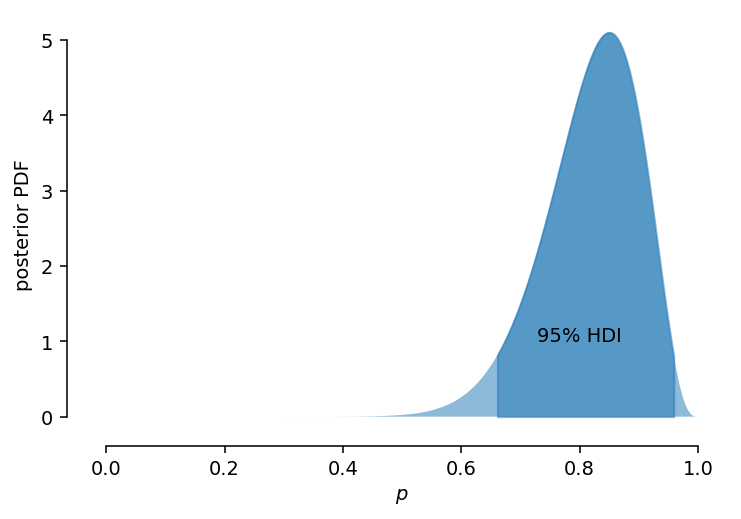

In [ ]:
#@title plot HDI
hdi_idxs = hdi(posterior)
plt.fill_between(ps, posterior, alpha=0.5)
plt.fill_between(ps[hdi_idxs], posterior[hdi_idxs], color='C0', alpha=0.5)
plt.text(0.8, 1, '95% HDI', ha='center')
plt.xlabel('$p$')
plt.ylabel('posterior PDF')
sns.despine(trim=True, offset=5);

# t-test
Say that we want to compare the firing of a neuron in response to stimulus A vs stimulus B. The spike count in response to each stimulus was recorded using 30 trials. Le'ts simulate the data in which response to stimulus B is slightly stronger.

In [ ]:
n = 30 # number of trials per stimulus

np.random.seed(seed=16)
A = np.random.poisson(5, n)
B = np.random.poisson(6, n)

Notice that we sample here from Poisson distributions with different means because it is very common to assume neurons fire Poissonly with varying rates. However, for the t-test we don't need to assume almost anything about the distribution that the firing actually comes from. This is because we know, given that the number of trials is not too small, that the mean response of each stimulus would distribute approximately t, regardless of the distribution (almost always). Later, in the bayesian version, we'll have to assume the distribution.

## Frequentist
### hypothesis testing

1. **Define a specific model we want to reject** <br>
    $$ H_0 : \mu_A = \mu_B $$
    
2. **Build a null distribution** <br>
We know that the difference between the means of the groups $\bar{A}-\bar{B}$ distributes $t$ with parameters shown below.

In [ ]:
SD = np.sqrt(np.mean([np.var(A), np.var(B)]))
SE = SD * 2 / n
H0distribution = tdist(2*n-2, scale=SE)
A_B = A.mean() - B.mean()
# t = (A.mean() - B.mean()) / SE

xs = np.arange(-3, 3, 0.01)*SE # x values we want to evaluate the distribution in. Ideally we 
PDF = H0distribution.pdf(xs) # probability density function

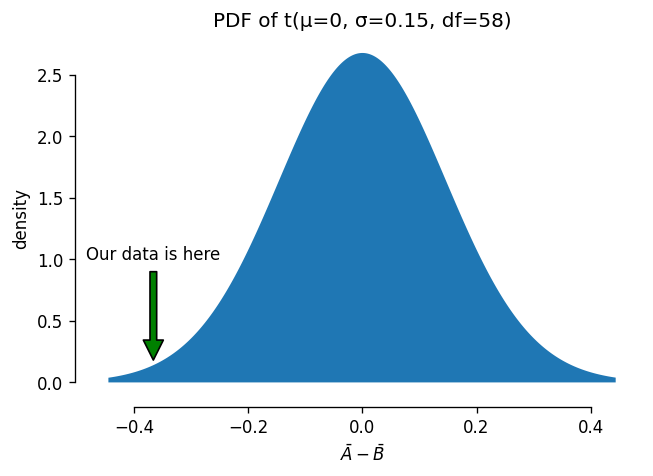

In [ ]:
#@title Plot t-distribution
plt.figure(dpi=120)
plt.fill_between(xs, PDF)
plt.xlabel(r'$\bar{A}-\bar{B}$')
plt.ylabel('density')
plt.annotate("Our data is here", xy=(A_B, H0distribution.pdf(A_B)), xytext=(A_B, 1), 
             arrowprops = dict(facecolor ='green', shrink = 0.05),
            horizontalalignment='center');
plt.title(f'PDF of t(μ=0, σ={SE:.2f}, df={2*n-2})');
sns.despine(trim=True, offset=5)

3. **Reject or retain the null hypothesis according to the *likelihood* of the data** (given the $H_0$ model) <br>

### hidden

In [ ]:
p_value = H0distribution.cdf(A_B)*2 # multiplied by 2 to account for the right extreme tail as well
print(f'p-value = {p_value:.3f}')

p-value = 0.016


In [ ]:
rate_A = 2
rate_B = 2
likelihood = poisson(rate_A).pmf(A).prod() * poisson(rate_B).pmf(B).prod()
print(likelihood)

1.7984834889145045e-102


Because every specific likelihood is tiny, it is better to work in log scale:

In [ ]:
rates = np.arange(0.1, 10, 0.1)
loglikelihood = np.array([[poisson(rate_A).logpmf(A).sum() + poisson(rate_B).logpmf(B).sum()
                           for rate_A in rates] for rate_B in rates])

In [ ]:
np.exp(loglikelihood)

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        4.99328494e-284, 1.14604000e-284, 2.58985260e-285],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        3.63330796e-237, 8.33903193e-238, 1.88447729e-238],
       [0.00000000e+000, 0.00000000e+000, 9.22874524e-313, ...,
        2.70408422e-210, 6.20631251e-211, 1.40251951e-211],
       ...,
       [3.57170372e-262, 1.26899916e-218, 1.09188145e-193, ...,
        3.19928584e-091, 7.34288067e-092, 1.65936430e-092],
       [9.17670158e-263, 3.26041226e-219, 2.80534754e-194, ...,
        8.21985632e-092, 1.88659054e-092, 4.26336901e-093],
       [2.31879411e-263, 8.23849905e-220, 7.08862904e-195, ...,
        2.07701583e-092, 4.76708869e-093, 1.07727977e-093]])

## Bayesian
1. Decide on how spikes are generated - likelihood function <br>
Say I have no idea that spikes are usually modelled as Poisson. I need to come up with some distribution with which the number of spikes in a trial is sampled from. Let's say I pick the geometric distribution, which parametrized by one parameter, denoted by $p$, where $1/p$ is the mean. <br>
Let's see an example:

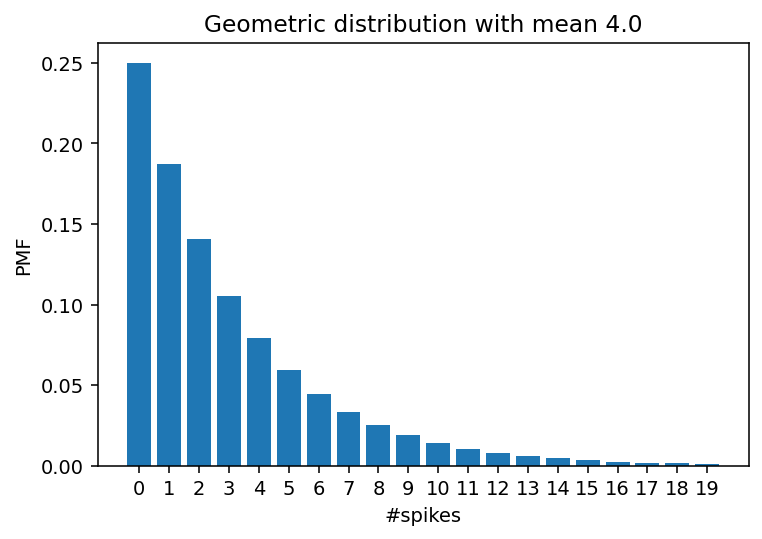

In [ ]:
p = 1/4
ks = np.arange(20) # values of #spikes to evaluate the geometric distribution in
plt.bar(ks, geom.pmf(ks+1, p))
plt.xticks(ks)
plt.title(f'Geometric distribution with mean {1/p}')
plt.ylabel('PMF')
plt.xlabel('#spikes');

What is the likelihood of a vector of #spikes i.e., the likelihood of the data from all trials of a given stimulus? <br>
It is proportional to the product of the likelihood of each trial, as they are independent. It is, of course, also dependent on the parameter of the distribution. We define a likelihood function:

In [ ]:
def GeometricLikelihood(spikes, p):
  return geom.pmf(spikes, p).prod()

2. Determine prior distribution. <br>
After we decided how we assume our data is generated (geometric distribution) we need to decide on a prior distribution its parameter $p$.  

The way we're computing here is highly unoptimized, but it is the most direct way. To be able to do it, let's decrease the number of trials to 10:

In [ ]:
n = 10 # number of trials per stimulus

np.random.seed(seed=16)
A = np.random.poisson(5, n)
B = np.random.poisson(6, n)